# train mlp on MNIST using fp32

In [1]:
import numpy as np
import tensorflow as tf
from dataset import load_mnist
from tensorflow import keras
from keras import layers

# load dataset
x_train, y_train, x_test, y_test = load_mnist(flatten=True)

In [2]:
class CustomRegularizer(keras.regularizers.Regularizer):
    def __init__(self):
        self.factor = 0.00000

    def __call__(self, x):
        return  self.factor * tf.reduce_sum(tf.abs(0.5-tf.abs(x)))
    
reg = CustomRegularizer()

In [3]:
x = x_in = keras.layers.Input((784))
x = keras.layers.Dense(256, kernel_regularizer=CustomRegularizer())(x)
x = keras.layers.ReLU()(x)
x = keras.layers.Dense(256, kernel_regularizer=CustomRegularizer())(x)
x = keras.layers.ReLU()(x)
x = keras.layers.Dense(10, kernel_regularizer=CustomRegularizer())(x)

mlp = keras.Model(inputs=[x_in], outputs=[x])
mlp.summary()
mlp.compile(optimizer=keras.optimizers.Adam(0.001), loss=keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.02), metrics=["accuracy"])
hist = mlp.fit(x_train, y_train, 256, 10, validation_data=(x_test, y_test))


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 re_lu (ReLU)                (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 re_lu_1 (ReLU)              (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                2570      
                                                                 
Total params: 269,322
Trainable params: 269,322
Non-trainable

In [4]:
from NeuralNetwork import QNeuralNetworkWithScale
import Activations
import FullyConnectedLayer 



# Define neural network inputnoutput
input_size = x_train.shape[1]
output_size = y_train.shape[1]

print(x_train.shape,
x_test.shape,
y_train.shape,
y_test.shape)

# Create and train the neural network
neural_network_with_scale = QNeuralNetworkWithScale(input_size, output_size)




(60000, 784) (10000, 784) (60000, 10) (10000, 10)
784 256
256 256
256 10


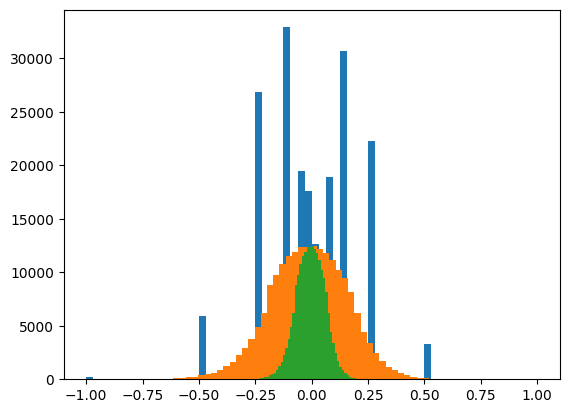

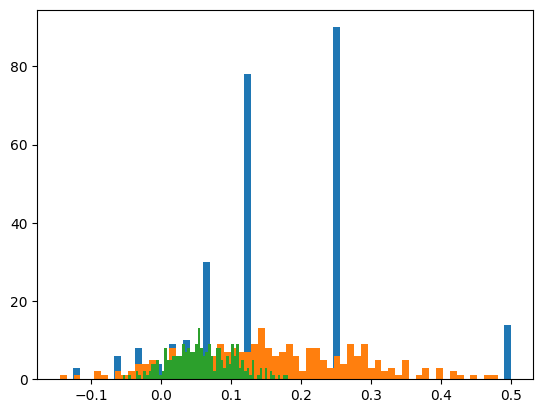

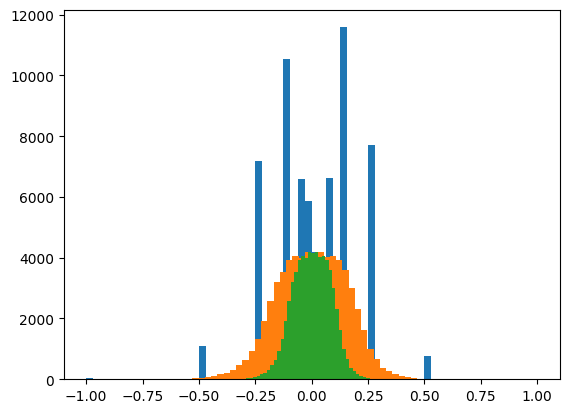

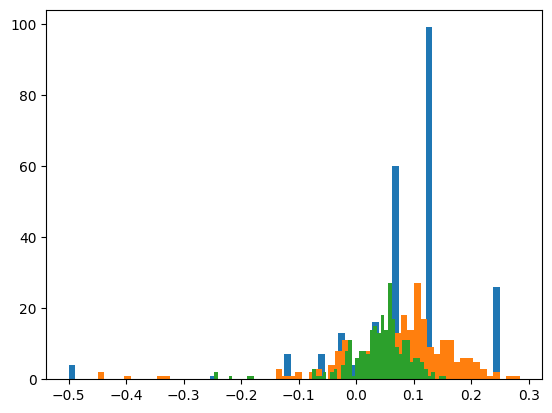

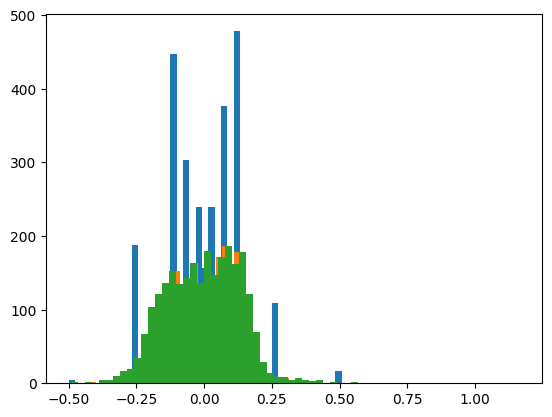

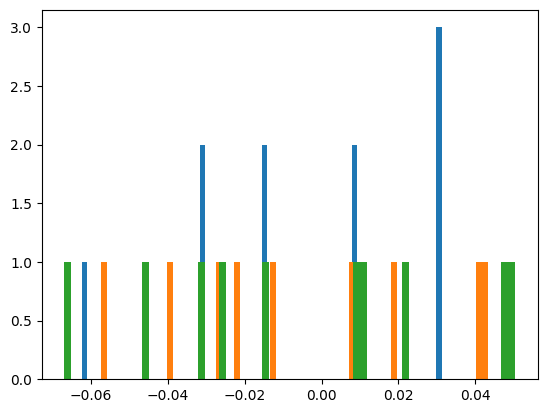

[<FullyConnectedLayer.QFullyConnectedLayerWithScale object at 0x0000021042BD12A0>, <Activations.QReLU object at 0x0000021083DFF700>, <FullyConnectedLayer.QFullyConnectedLayerWithScale object at 0x0000021083E5AF80>, <Activations.QReLU object at 0x0000021084258F10>, <FullyConnectedLayer.QFullyConnectedLayerWithScale object at 0x0000021084258F70>]


In [5]:
# como vincular um modelo com o outro?
# mais vale criar um modelo do 0 com base no modelo q vier...
# o problema maior é criar cada camada
# a rede é só um array de camadas

import matplotlib.pyplot as plt
import quantizer

dn_layers = []
for l in mlp.layers:
    if isinstance(l, keras.layers.Dense):        
        
        qfc = FullyConnectedLayer.QFullyConnectedLayerWithScale(l.weights[0].shape[0],l.weights[0].shape[1])
        
        fpw = l.weights[0].numpy()        
        fpb  = l.weights[1].numpy()
        
        w_scale = np.max(np.abs(fpw))
        
        fpw_scaled = fpw / w_scale
        qw = quantizer.quantize(fpw_scaled, True, False)
        
        # atribui o peso quantizado
        qfc.qw = qw
        qfc.weights_scale = fpw_scaled
               

        plt.hist(np.ravel(qw), bins=64)
        plt.hist(np.ravel(fpw_scaled), bins=64)
        plt.hist(np.ravel(fpw), bins=64)
        plt.show()

        
        fpb_scaled = fpb / w_scale
        qb = quantizer.quantize(fpb_scaled, True, False)
        qfc.qb = qb
        plt.hist(np.ravel(qb), bins=64)
        plt.hist(np.ravel(fpb_scaled), bins=64)
        plt.hist(np.ravel(fpb), bins=64)
        plt.show()


        dn_layers.append(qfc)


    if isinstance(l, keras.layers.ReLU):                
        dn_layers.append(Activations.QReLU())

print(dn_layers)




In [6]:
neural_network_with_scale.load_layers_from_model(mlp)

instantiating weights from  dense
instantiating relu
instantiating weights from  dense_1
instantiating relu
instantiating weights from  dense_2
loaded layers [<FullyConnectedLayer.QFullyConnectedLayerWithScale object at 0x0000020D58DFDFC0>, <Activations.QReLU object at 0x0000020D57560BB0>, <FullyConnectedLayer.QFullyConnectedLayerWithScale object at 0x00000210841868F0>, <Activations.QReLU object at 0x0000021084459030>, <FullyConnectedLayer.QFullyConnectedLayerWithScale object at 0x0000021084458DF0>]


In [7]:
y_pred = neural_network_with_scale.predict(x_test, 256)

# Calculate accuracy
accuracy = tf.reduce_mean(tf.cast(y_pred == tf.argmax(y_test, axis=1), tf.float32))
print(f"Accuracy: {accuracy * 100}%")

Accuracy: 97.37999725341797%


In [8]:
# finetune the dnn
neural_network_with_scale.train(x_train, y_train, learning_rate=0.000010, num_epochs=10, batch_size=256, x_val=x_test, y_val=y_test)


Epoch 1/10, Loss: 0.00014964956790208817 Accuracy: 97.16999816894531%
Epoch 2/10, Loss: 0.00011364130477886647 Accuracy: 97.69999694824219%
Epoch 3/10, Loss: 0.00010252041829517111 Accuracy: 97.75%
Epoch 4/10, Loss: 9.704538388177752e-05 Accuracy: 97.69999694824219%
Epoch 5/10, Loss: 8.988605259219185e-05 Accuracy: 97.75%
Epoch 6/10, Loss: 9.076650167116895e-05 Accuracy: 97.8699951171875%
Epoch 7/10, Loss: 9.091023093787953e-05 Accuracy: 97.63999938964844%
Epoch 8/10, Loss: 9.016806143335998e-05 Accuracy: 97.66999816894531%
Epoch 9/10, Loss: 8.788699051365256e-05 Accuracy: 97.88999938964844%
Epoch 10/10, Loss: 8.569387864554301e-05 Accuracy: 97.66999816894531%
